In [1]:
from myTreecode import Star
from myTreecode import Tree
from myTreecode import grav_force_star_node
from myTreecode import evolve
from view import view
import numpy as np
import numpy.random as random

**TREE-CODE**

This algorithm does an approximation on the force computation. 
Given N particles in a volume V, tree-code devides teh volume iteratively into cubes up to the point each one contains only 1 particle. 
When the force acting over one particle i is computed, particles sufficiently far away from it are grouped in one point (the center ??) and their mass is sum up in total mass M. This is equal to take only the first order of the multipolar expansion (monopole term).

Computational cost: $N\log(N)$

Leaf opening criterion: $\theta = r_{cell}/d < \theta_{crit}$ 

$\theta_{crit}$ is the accuracy parameter (<<1 radiant)

Gravitational softening: to avoid huge scatterings we set the force different from newtonian one if the particles get to much close:

$|f_{ij}|=\frac{Gm_im_j}{|r_i-r_j|^2+\epsilon^2}$

does not diverge: it's like the mass of each particle has been smoothed over a finite volume.

Time integration: LEAP-FROG method. $t_i -> t_{i+1}$

$v_{i+\frac{1}{2}}=v_i+(\frac{h}{2})a_i$

$r_{i+1}=r_i+hv_{i+\frac{1}{2}}$

$v_{i+1}=v_{i+\frac{1}{2}}+(\frac{h}{2})a_i$

h is NOT ADAPTIVE, it's set at imput. We will set $h<<t_{dyn}$

$\epsilon = 10^{-4}(V/N)^{1/3}$

**INTERNAL UNITS**

nbody_sh1 and treecode work with internal units. $G_{iu}$ is set equal to 1. We are free to express masses and distances in arbitrary units, as far as velocities and times are consistent. In order to see that, notice that $\frac{GM}{rv^2}$ is adimensional. 

$$\frac{M_{iu}}{r_{iu}v_{iu}^2}=\frac{G_{cgs}M_{cgs}}{r_{cgs}v_{cgs}^2}$$

Velocities in internal units will be related to physical velocities by:

$$v_{iu}=\sqrt{\frac{r_{cgs}}{G_{cgs}M_{cgs}}}v_{cgs}$$

We need to tranform time units in internal units as well. $\frac{rt}{v}$ is adimensional. 

$$\frac{t_{iu}v_{iu}}{r_{iu}}=\frac{t_{cgs}v_{cgs}}{r_{cgs}}$$

$$t_{iu}=\frac{r_{iu}}{r_{cgs}}\sqrt{\frac{r_{cgs}}{G_{cgs}M_{cgs}}}t_{cgs}$$

In [2]:
c_cgs = 2.99792458 * 10**10 #cm/s
G_cgs = 6.67259 * 10**-8 #G in cgs
M_sun = 1.9891 * 10**33 #solar mass in g
R_sun = 6.9598 * 10**10 #solar radius in cm 
M_earth = 5.976 * 10**27 #earth mass in g
R_earth = 6.378 * 10**8 #earth radius in cm
ly = 9.463 * 10**17 #light year in cm
parsec = 3.086 * 10**18 #parsec in cm
AU = 1.496 * 10**13 #astronomical unit in cm
Sun_shw = 2*G_cgs*M_sun/(c_cgs**2) #Sun's Schwarschild radius in cgs

kB = 1.380649 * 10**-16 #erg/K

def v_IU(M_cgs, r_cgs, v_cgs):
    return np.sqrt(r_cgs/(G_cgs*M_cgs))*v_cgs

def c_IU(M_cgs, r_cgs):
    return np.sqrt(r_cgs/(G_cgs*M_cgs))*c_cgs

def t_IU(M_cgs, r_cgs, t_cgs):
    return t_cgs/(np.sqrt(r_cgs/(G_cgs*M_cgs))*r_cgs)

#print("If we choose 1 solar mass as mass unit and 1 parsec unit as distance unit:")
#print("1 Myr expressed in internal units is: %f" % (t_IU(M_sun,parsec,3.156*10**13)))
#print("1 time unit expressed in cgs is: %f Myrs" % (1/t_IU(M_sun,parsec,3.156*10**13)))
#print("1 time unit expressed in cgs is: %f s" % (1/t_IU(M_sun,parsec,1)))
#print("Light speed expressed in internal units is: %E" % (c_IU(M_sun,parsec)))
#print("Sun rest mass energy in internal units is: %E" %(1*c_IU(M_sun,parsec)))
#print("Sun kinetic energy (0.5M(200km/s) = %E erg) in internal units is: %E" %(0.5*M_sun*(200*10**5)**2, 0.5*v_IU(M_sun, parsec, 200*10**5)))
#print("1 km/s in internal units is: %f" %(v_IU(M_sun, parsec, 1*10**5)))

time_conversion_factor = 0.067069       # 1 Myr in internal units
energy_conversion_factor = 1/1524.834   # sun kinetic energy in internal units
velocity_conversion_factor = 15.248335  # Km/s in internal units



**GENERATING PLUMMER SPHERE**

$$p(r) = \frac{1}{M} 4 \pi r^2 \rho(r) =  \frac{1}{M} 4 \pi r^2 \frac{3M}{4\pi b^3} \left(1+\frac{r^2}{b^2}\right)^{-5/2} = \frac{3r^2}{ b^3} \left(1+\frac{r^2}{b^2}\right)^{-5/2}$$

$$P(r) =  \int_0^r p(r) dr = \frac{r^3}{b^3\left(1+\frac{r^2}{b^2}\right)^{3/2}}$$ (by parts and with $tan$ sobstitution)

It's mush easier to derive the potential:
 
$$p(r)=\frac{1}{M} 4 \pi r^2 \rho(r)=\frac{1}{M} 4 \pi \frac{\nabla^2\Phi}{4\pi G}=\frac{1}{GM}\frac{d}{dr}\left(r^2 \frac{d\Phi}{dr}\right)$$ 

$$P(r) =  \int_0^r p(r) dr = \frac{1}{GM} r^2 \frac{d\Phi}{dr} =  \frac{1}{GM} r^2\frac{d}{dr} \left( -\frac{GM}{\sqrt{r^2+b^2}}\right)=\frac{r^3}{b^3\left(1+\frac{r^2}{b^2}\right)^{3/2}}$$

$$\int_0^\infty p(r) dr = 1$$

$r/b=\sinh(x)$ ; $P=\tanh^3(x)$ ; $r=b\sinh(arctanh(P^{1/3}))$

Generating velocity distribution. For a spherical ergodic system: 

$$\nu(r) = \frac{\rho(r)}{M} = 4\pi \int_0^\Psi dvv^2 f(\Psi-1/2v^2)$$

where $\Psi = -\Phi + \Phi_0$ and $\varepsilon = -H +\Phi_0 = \Psi - 1/2v^2$

$$\int_0^\infty dr\nu(r) = 1 = \int d^3x 4\pi \int_0^\Psi dvv^2 f(\Psi-1/2v^2)$$ 



In [3]:

class Plummer:
    
    def __init__(self,N,b,m=1):
        self.N = int(N) 
        self.b = b 
        self.m = m 
        self.M = N*self.m 
        self.rho0 = 3*self.M/(4*np.pi*self.b**3)
 
        print(f"Plummer sphere of {self.N} stars and total mass {self.M:.2f} solar masses. "
              f"Scale parameter b is {self.b:.2f} parsecs.")

                
        self.v_typical = np.sqrt(self.M/self.b)  # from virial theorem
        self.t_cross = self.v_typical / self.b        
        self.t_relax = (0.1 * self.N / np.log(self.N)) * self.t_cross

        print(f"Characteristic velocity is {self.v_typical:.2e} in internal units, "
              f"{self.v_typical * velocity_conversion_factor:.2e} km/s. ")
        print(f"Crossing time is {self.t_cross:.2e} in internal units, "
              f"{self.t_cross * time_conversion_factor:.2e} Myr. "
              f"Relaxation time is {self.t_relax:.2e} in internal units, "
              f"{self.t_relax * time_conversion_factor:.2e} Myr.")

        # initialize system
        
        self.t = [0]
        self.system = []

        initial_conditions = []
        
        for i in range(self.N):
            
            u = random.uniform(0,1)
            v = random.uniform(0,1)
            w = random.uniform(0,1)
            r = self.b * np.sinh(np.arctanh(u**(1/3))) 
            theta = np.arccos(1-2*v) 
            phi = 2*np.pi*w
            
            x = np.array([r*np.sin(theta)*np.cos(phi),r*np.sin(theta)*np.sin(phi),r*np.cos(theta)])
            Psi_x = self.M/np.sqrt(r**2 + self.b**2)
            
            # extract a point from velocity distribution ranging from 0 to q = 1 (v = v_esc)
            norm = 7*np.pi/512   ### serve?
            while True:
                q = random.uniform(0,1) 
                y = random.uniform(0,0.093/norm) 
                if y < (1/norm) * q**2 * (1-q**2)**(7/2):
                    break
                    
            v_magn = q * np.sqrt(2*Psi_x)
            theta = np.arccos(1-2*random.uniform(0,1)) 
            phi = 2*np.pi*random.uniform(0,1)
            
            v = np.array([v_magn*np.sin(theta)*np.cos(phi),v_magn*np.sin(theta)*np.sin(phi),v_magn*np.cos(theta)])
            
            initial_conditions.append(Star(self.m, x, v))
            
        self.system.append(np.array(initial_conditions))






In [6]:
plum = Plummer(300,10)

#from copy import deepcopy

evolve(plum,tstop = 10,dt = 0.1,dtout=0.3,eps=0.001,orbit_indexes=[20,60,70])

Plummer sphere of 300 stars and total mass 300.00 solar masses. Scale parameter b is 10.00 parsecs.
Characteristic velocity is 5.48e+00 in internal units, 8.35e+01 km/s. 
Crossing time is 5.48e-01 in internal units, 3.67e-02 Myr. Relaxation time is 2.88e+00 in internal units, 1.93e-01 Myr.


Evolving system:   0%|          | 0/10 [00:00<?, ?it/s]

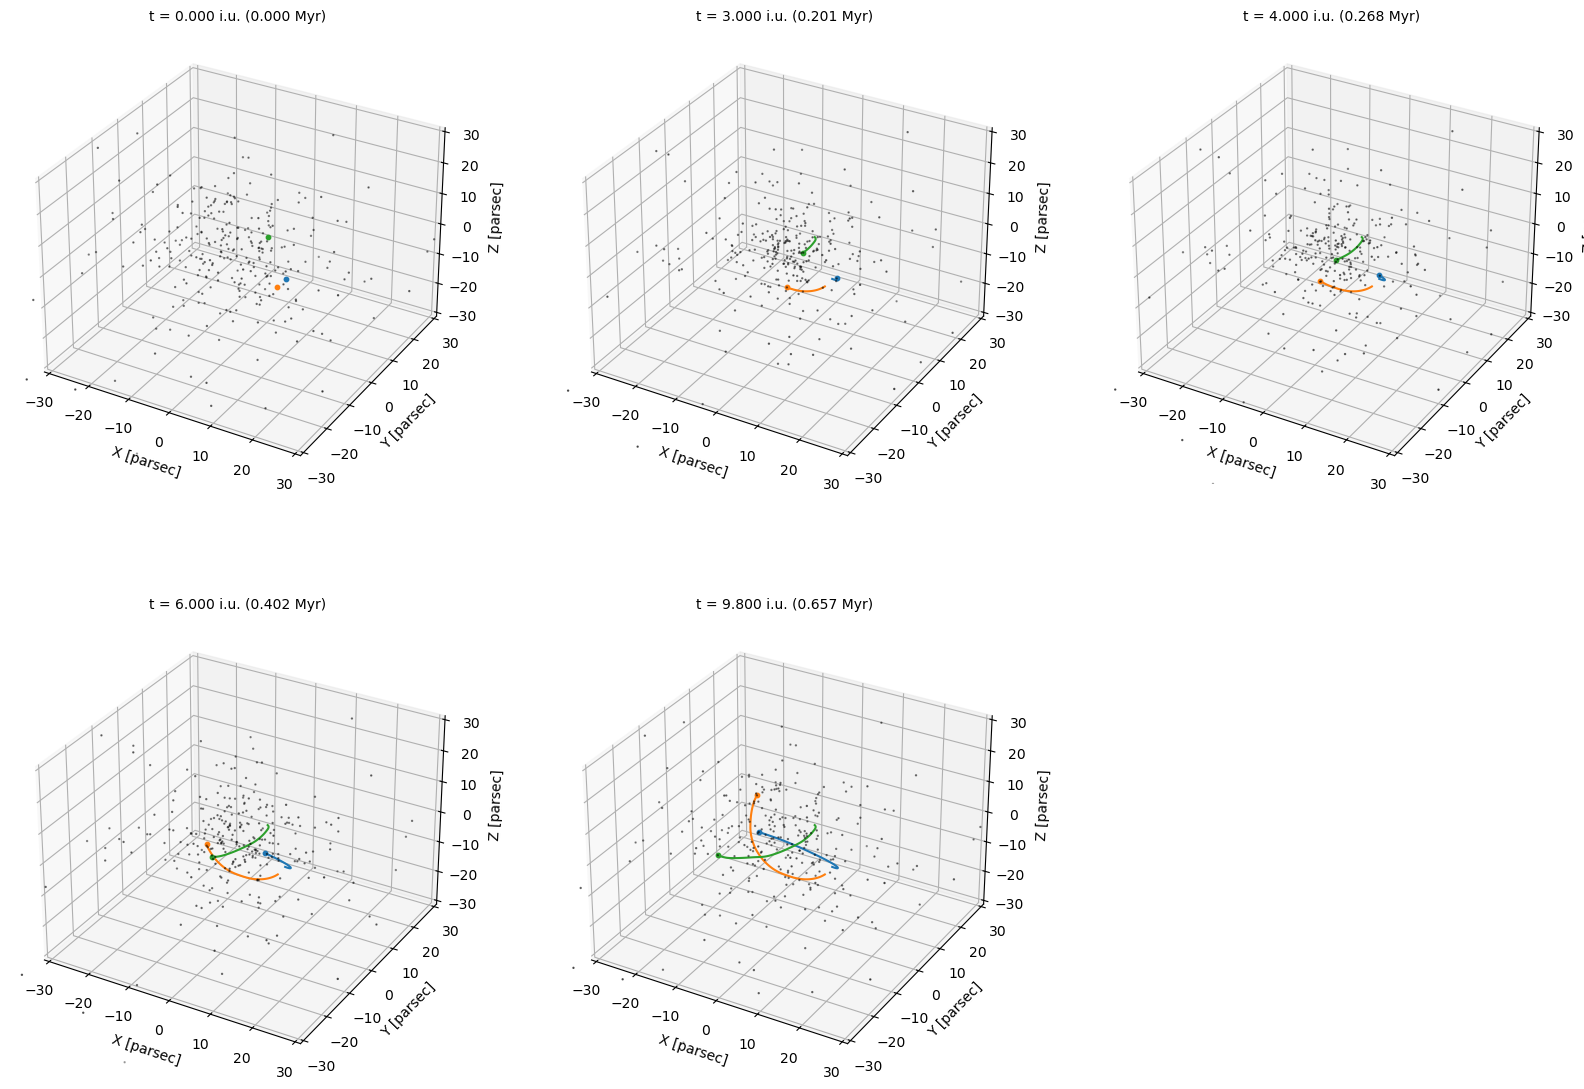

In [8]:
view(plum,r_max=30, t=[0,3,4,6,10],orbit_indexes=[20,60,70])